In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats


In [2]:
############### Synthetic Data #############
β = 0.005
μ2 = 1/21 #14 days infectious
μ1 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ϵ = 0.0001
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0]
parameters = [Input_H, capT] 

In [3]:
def gillespieSEIR(initial, beta, mu1,mu2, sigma, epsilon,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]>0):
        state = np.zeros(shape= (4,4))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]
        
        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]

        
        rate = [R_se, R_ei, R_ir, R_is]

        Rtotal = sum(rate)
#         print(Rtotal)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
#         total_inf = sum(cuminf)
        if event == 1:
            cuminf.append(1 + cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:3])
    return event_time, np.array(pop), events, cuminf

In [7]:
M =gillespieSEIR(parameters[0], β, μ1, μ2, σ, ϵ,  parameters[1])
time = [] #make results of M a step function
cuminf = [] #steps
for ind, x in enumerate(M[0]):
    if ind < len(M[0])-1:
        time.append((M[0][ind], M[0][ind+1]))
        cuminf.append((M[3][ind], M[3][ind]))
time = np.array(time).flatten()
cuminf = np.array(cuminf).flatten()
max_inf = max(cuminf)
max_time = math.ceil(max(time))


intert = np.arange(0, max_time +1 , 1) #interpolate to daily steps
intercum = np.interp(intert, time,cuminf) #daily steps


In [8]:
intert = np.array(intert, dtype = int)
intercum

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  9., 10., 11., 11., 11., 11., 11., 12., 13., 13.,
       14., 14., 14., 14., 14., 14.])

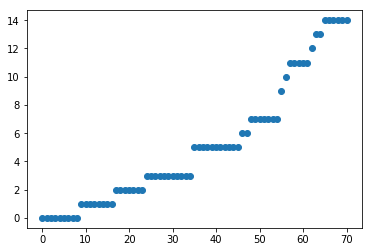

In [9]:
plt.plot(intert, intercum, 'o') # This is the synthetic data
summary = np.array([[int(a) for a in intert], [int(b) for b in intercum]])

# Perform ABC on the synthetic data

In [ ]:
N = 200
tol = 50
t = 0 
θ = []

β1, ɛ1, σ1, μ11,μ21 =  [np.random.uniform(0,0.1, N), np.random.uniform(0,0.001, N),
                     1/np.random.uniform(1,30, N), 1/np.random.uniform(1, 40, N),
                     1/np.random.uniform(1,40, N)]
#     print(np.array([β1, ɛ1, p1 ]))

θ = [np.array([β1, ɛ1, σ1, μ11, μ21]).T]
# print(θ[0][:,0])
t = 1
θ_t = []
tols = []
tols.append(tol)
error = []
while t< 6:
    r_β = np.random.randint(0, N-1)
    r_ϵ = np.random.randint(0,N-1)
    r_σ= np.random.randint(0,N-1)
    r_μ1 = np.random.randint(0,N-1)
    r_μ2 = np.random.randint(0,N-1)
    δ = np.random.uniform(0, 1e-3)
    βt, ɛt, σt, μ1t, μ2t = θ[t-1][:,0][r_β] +δ, θ[t-1][:,1][r_ϵ] +δ,θ[t-1][:,2][r_σ] + δ, θ[t-1][:,3][r_μ1] +δ, θ[t-1][:,4][r_μ2] +δ

    M =gillespieSEIR(parameters[0], βt, μ1t,μ2t,σt,ɛt,  parameters[1])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = summary[0]
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = summary[1]
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 3)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    
#         print(summary_time, summary_cum)
#     print(np.linalg.norm(summary_cum-inter_cum[summary_time]), βt, ɛt, pt)
    if np.linalg.norm(summary_cum-inter_cum[summary_time]) <tol:
        θ_t.append(np.array([βt, ɛt, σt, μ1t, μ2t]))
        print(len(θ_t), t, tol, np.linalg.norm(summary_cum-inter_cum[summary_time]))
#             θ_t = np.array(θ_t)
#             print(θ_t)
        error.append(np.linalg.norm(summary_cum-inter_cum[summary_time]))
    if len(θ_t) == N:
        tol = np.median(error)
        tols.append(tol)
        θ_t = np.array(θ_t)
        print(θ_t)
        θ.append(θ_t)
        t +=1 
        θ_t = []
        error = []

1 1 50 28.965496715920477
2 1 50 33.46640106136302
3 1 50 40.44749683231337
4 1 50 25.65151067676132
5 1 50 40.74309757492672
6 1 50 45.67274898667694
7 1 50 40.4103947023535
8 1 50 40.36087214122113
9 1 50 41.036569057366385
10 1 50 30.066592756745816
11 1 50 40.3732584763727
12 1 50 45.79301256742124
13 1 50 39.96248240537617
14 1 50 45.2658811910251
15 1 50 41.7492514902962
16 1 50 45.552167895721496
17 1 50 40.496913462633174
18 1 50 45.44227107000705
19 1 50 45.2658811910251
20 1 50 45.4972526643093
21 1 50 45.36518488885502
22 1 50 41.02438299353203
23 1 50 30.692018506445613
24 1 50 34.46737587922817
25 1 50 33.8673884437522
26 1 50 45.58508528016593
27 1 50 31.96873472629156
28 1 50 40.58324777540605
29 1 50 45.39823785126467
30 1 50 39.89987468652001
31 1 50 45.4972526643093
32 1 50 10.583005244258363
33 1 50 38.47076812334269
34 1 50 36.6333181680284
35 1 50 41.19465984809196
36 1 50 40.92676385936225
37 1 50 44.955533585978046
38 1 50 37.429934544425805
39 1 50 29.8998327754

1 2 40.14348827576208 29.614185789921695
2 2 40.14348827576208 31.71750305430741
3 2 40.14348827576208 36.6742416417845
4 2 40.14348827576208 36.71511950137164
5 2 40.14348827576208 35.6931365951495
6 2 40.14348827576208 33.075670817082454
7 2 40.14348827576208 32.7566787083184
8 2 40.14348827576208 30.347981810987037
9 2 40.14348827576208 39.11521443121589
10 2 40.14348827576208 37.469987990390386
11 2 40.14348827576208 34.77067730142742
12 2 40.14348827576208 38.897300677553446
13 2 40.14348827576208 35.608987629529715
14 2 40.14348827576208 34.40930106817051
15 2 40.14348827576208 35.270384177096794
16 2 40.14348827576208 35.199431813596085
17 2 40.14348827576208 35.08560958569767
18 2 40.14348827576208 32.60368077380221
19 2 40.14348827576208 36.4828726939094
20 2 40.14348827576208 38.157568056677825
21 2 40.14348827576208 36.05551275463989
22 2 40.14348827576208 31.906112267087632
23 2 40.14348827576208 35.17101079013795
24 2 40.14348827576208 32.12475680841802
25 2 40.14348827576

199 2 40.14348827576208 36.180105030251084
200 2 40.14348827576208 36.53765181289022
[[4.60306919e-02 1.42772441e-04 1.79817496e-01 5.35733867e-01
  4.55835925e-01]
 [1.72297365e-03 2.25057913e-04 2.31472812e-01 5.34942281e-01
  4.34147047e-02]
 [1.24091626e-02 1.84413416e-04 2.12381040e-01 1.59975330e-01
  9.64743333e-02]
 [1.97549168e-02 2.70301992e-04 2.42691930e-01 4.48309718e-02
  3.23395822e-01]
 [2.33379124e-02 8.02358032e-04 4.55994022e-01 4.64837064e-02
  4.36542050e-01]
 [2.08405728e-02 2.52206783e-04 1.79983492e-01 7.07297258e-02
  4.34768191e-02]
 [2.69867890e-02 1.66993774e-04 2.09248842e-01 5.46607619e-01
  3.23222213e-01]
 [7.16162501e-02 2.71797071e-04 1.51614587e-01 3.01360713e-02
  4.36564435e-01]
 [5.48433397e-02 3.09360236e-04 1.81418830e-01 7.73248041e-01
  7.13605430e-02]
 [2.12568728e-02 3.81259174e-04 4.55897253e-01 3.13729130e-02
  3.23425821e-01]
 [2.09553826e-02 1.43847639e-04 6.75606605e-01 2.71037228e-02
  2.06882779e-01]
 [1.72423511e-02 3.94009976e-04 4.1

1 3 34.65544389904849 33.71943060017473
2 3 34.65544389904849 31.670175244226233
3 3 34.65544389904849 23.194827009486403
4 3 34.65544389904849 32.78719262151
5 3 34.65544389904849 28.792360097775937
6 3 34.65544389904849 32.2335229225724
7 3 34.65544389904849 34.219877264537345
8 3 34.65544389904849 30.83828789021855
9 3 34.65544389904849 16.61324772583615
10 3 34.65544389904849 33.97057550292606
11 3 34.65544389904849 34.62657938636157
12 3 34.65544389904849 32.449961479175904
13 3 34.65544389904849 31.496031496047245
14 3 34.65544389904849 34.11744421846396
15 3 34.65544389904849 28.792360097775937
16 3 34.65544389904849 18.81488772222678
17 3 34.65544389904849 34.46737587922817
18 3 34.65544389904849 33.481338085566414
19 3 34.65544389904849 25.826343140289914
20 3 34.65544389904849 34.11744421846396
21 3 34.65544389904849 33.03028912982749
22 3 34.65544389904849 13.711309200802088
23 3 34.65544389904849 32.38826948140329
24 3 34.65544389904849 34.307433596816885
25 3 34.6554438990

In [ ]:
len(summary_cum)
len(inter_cum)
summary_time

In [ ]:
α

In [ ]:
np.save('theta_synthetic_SEIR', θ)
np.save('tols_synthetic_SEIR', tols)

In [ ]:
plt.figure(figsize = (20,20))
tol = 6
for i in range(6):
    plt.subplot(3,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.plot(β, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(3,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.plot(ϵ, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,3)
    plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(50), 'o' )
    plt.xlabel('σ - exposed', fontsize = 20)
    plt.plot(1/σ, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,5)
    plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(50), 'o' )
    plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
    plt.plot(1/μ1, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])        
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,6)
    plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(50), 'o' )
    plt.xlabel('μ2 - days until death from disease', fontsize = 20)
    plt.plot(1/μ2, 0, 'X',markersize = 10, color = 'k')

    plt.yticks([])        
    plt.xticks(fontsize = 16)
    

In [ ]:
plt.figure(figsize = (20,20))

plt.subplot(3,2,1)
#     plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,0],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,0],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot(β, 0, 'X',markersize = 10, color = 'k')
plt.xlabel('β - person to person transmission', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,2)
#     plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,1],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,1],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot(ϵ, 0, 'X',markersize = 10, color = 'k')
plt.xlabel('ɛ - external infection', fontsize = 20)
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,3)
#     plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,2]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,2]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('σ - exposed', fontsize = 20)
plt.plot(1/σ, 0, 'X',markersize = 10, color = 'k')
plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,5)
sns.distplot([1/a for a in θ[0][:,3]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,3]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(50), 'o' )
plt.plot(1/μ1, 0, 'X',markersize = 10, color = 'k')
plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
plt.yticks([])        
plt.xticks(fontsize = 16)

plt.subplot(3,2,6)
#     plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,4]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,4]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('μ2 - days until death from disease', fontsize = 20)
plt.plot(1/μ2, 0, 'X',markersize = 10, color = 'k')
plt.yticks([])        
plt.xticks(fontsize = 16)


# Test the ABC on synthetic data

In [ ]:
parameters = [Input_H, μ1, μ2, σ, ω, 1, capT]
r_β = np.random.randint(0, 49)
r_ϵ = np.random.randint(0,49)
r_σ = np.random.randint(0,49)
r_μ1 = np.random.randint(0,49)
r_μ2 = np.random.randint(0,49)
betas = θ[5][:,0]
eps = θ[5][:,1]
sigmas = θ[5][:,2]
mus1 = θ[5][:,3]
mus2 = θ[5][:,4]

In [ ]:
Rec_syn = summary[0]
Cum_syn = summary[1]
Rec_syn

In [ ]:
timing = []
cumulative = []
for k in range(1000):
    r_β = np.random.randint(0, 49)
    r_ϵ = np.random.randint(0,49)
    r_σ = np.random.randint(0,49)
    r_μ1 = np.random.randint(0,49)
    r_μ2 = np.random.randint(0,49)
    M=gillespieSEIR(parameters[0], betas[r_β], mus1[r_μ1],mus2[r_μ2],
                          sigmas[r_σ],eps[r_ϵ],  parameters[6])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
    #     print(max_inf, max_time, βt, ɛt)


    summary_time = Rec_syn
    #         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = Cum_syn
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 1)
        summary_time = np.append(summary_time, length1)
    #         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(Cum_syn)*np.ones(len(length1 )))
    #         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))

    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    timing.append(inter_t)
    cumulative.append(inter_cum)
    #         print(summary_time, summary_cum)
#     print(np.linalg.norm(summary_cum-inter_cum[summary_time]),  betas[r_β], mus1[r_μ1],mus2[r_μ2],
#                           sigmas[r_σ],eps[r_ϵ])
    

In [ ]:
plt.figure(figsize = (20,8))
for j in range(200):
    plt.plot(timing[j], cumulative[j], 'o', color = 'orange', alpha = 0.4)

plt.plot(summary_time, summary_cum, 'o', color = 'grey')
plt.xlim([0,50])
plt.ylim([0,100])

In [ ]:
sun_cum = np.zeros(28)
for k in range(28):
    for j in range(200):
        if timing[j][-1]<k:
            sun_cum[k] +=0
        else:
            sun_cum[k] += cumulative[j][k]
cumulative = np.array(cumulative)

In [ ]:
mat = np.zeros(shape=(200, 29))
for k in range(200):
    mat[k,:] = cumulative[k][:29]

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(range(29), np.mean(mat, axis = 0), 'x', markersize = 10,linewidth = 6, color = '#fdfdfe', label = 'Mean')
plt.plot(range(29), (np.mean(mat, axis = 0)+np.std(mat, axis = 0)), color ='k', lw=0.5)
plt.plot(range(29), np.maximum((np.mean(mat, axis = 0)-np.std(mat, axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(range(29),  (np.mean(mat, axis = 0)+np.std(mat, axis = 0)), np.maximum((np.mean(mat, axis = 0)-np.std(mat, axis = 0)),0), 1, alpha=0.3, color = 'purple')
ax.plot(summary_time, summary_cum, 'o', color = 'black', label = 'real case data')
# leg = ax.legend(fontsize = 20)
plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
plt.xlabel('Time, days', fontsize = 20)